## What packages you need
- `numpy`
- `scipy`: to find the ignition delays based on the inflection point of temperature
- `cantera`: for kinetics data
- `pytorch`: for nueral net fitting

*optional*

- `tqdm`: for give the nice progress bar for training net
- `sklearn`: for scaling data before training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
from scipy.interpolate import UnivariateSpline
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn

#### Some optional matplotlib customization

In [2]:
# Matplotlib setup
plt.style.use('seaborn-white')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=20)
plt.rc('font', family='serif')

### Mechanism and parameters for ignition in constant pressure
- The detailed mechanism of syngas from Li (2015)
- The input file is the text file have information for integration similar to conp.inp in chemkin

In [3]:
# Reading the mechanism
reaction_mechanism = 'syngas_chem_Li2015_wetCO_mech.cti'
# Reading the input file input.var
input_var = []
with open("syngas_input.var", "r") as txt:
    for line in txt:
        if not (line[0]=='!'):
           input_var.append(line)
phi     = float(input_var[0])       # [-]
p       = float(input_var[1])       # [atm]
T_in_min= float(input_var[2])       # [K]
T_in_max= float(input_var[3])       # [K]
step_T  = int(input_var[4])         # [K]
Trange  = np.linspace(T_in_min, T_in_max, num =step_T)
t_final = float(input_var[5])       # [s]
dt      = float(input_var[6])
lenght_timeseries = t_final/dt

In [4]:
# Loading a mechanism
gas = ct.Solution(reaction_mechanism)
# Find the number of species and reactions
ns = gas.n_species
nr = gas.n_reactions
print ("The mechanism includes {} number of species and {} number of reactions".format(ns, nr))

The mechanism includes 12 number of species and 37 number of reactions


### Generate dataset
- The full dataset includes time, pressure, temperature and mass fractions stored columnwise. In total $n_s$+3
columns.
- The name of generated dataset is `dataset`.
- `num`: is the number of point to fit function on temperature to get its derivative and find the infelection point and ignition delay time.

In [5]:
# dataset includes 
dataset = np.empty((0, ns+3))
num     = 10000   # number of interpolation points
t_ign   = []      # empty list for ignition delay times
print ('{:10}\t{:10}'.format('T [K]','ign [s]'))
for T in Trange:
    # Setting the state
    # Temperature and pressure
    gas.TPX = T, p*ct.one_atm, \
            {'CO':1, 'H2':3, 'O2': 2.0/phi, \
             'N2':2.0*(79./21.)/phi}
    r = ct.IdealGasConstPressureReactor(gas)
    sim = ct.ReactorNet([r])
    time = 0.0
    tt = []     # time
    TT = []     # temperature
    YY = []     # mass fractions
    while time<t_final:
        time = time + dt
        sim.advance(time)
        tt.append(time)
        TT.append(r.T)
        YY.append(r.Y)    
    # Dataset creation
    tt = np.array(tt)
    PP = p*ct.one_atm*np.ones(np.size(tt))
    TT = np.array(TT)
    YY = np.array(YY)
    dataset = np.append(dataset, np.c_[tt, PP, TT,YY], axis=0)
    # Fit a curve on T-t ignition history
    f      = UnivariateSpline(tt, TT)
    # Find dT/dt
    df     = f.derivative()
    tt_new = np.linspace(tt[0], tt[-1], num=num, endpoint=True)
    i = 0
    ign_time = tt_new[i]
    while i<=num-1:
        if df(tt_new[i])>df(ign_time):
            ign_time = tt_new[i]
        i = i+1
    t_ign.append(ign_time)
    print ('{:8.4f}\t{:8f}'.format(T,ign_time))

t_ign = np.array(t_ign)

T [K]     	ign [s]   
1000.0000	0.000207
1026.3158	0.000155
1052.6316	0.000122
1078.9474	0.000098
1105.2632	0.000082
1131.5789	0.000069
1157.8947	0.000058
1184.2105	0.000051
1210.5263	0.000044
1236.8421	0.000038
1263.1579	0.000034
1289.4737	0.000030
1315.7895	0.000028
1342.1053	0.000025
1368.4211	0.000022
1394.7368	0.000020
1421.0526	0.000019
1447.3684	0.000017
1473.6842	0.000015
1500.0000	0.000015


### Plots
- We have usual ignition delay vs 1000/T_0
- Timeseries of temperature vs time

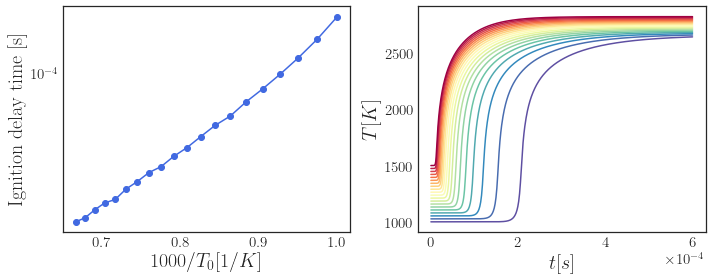

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(1000./Trange, t_ign, '-o', c='royalblue')
ax1.set_yscale('log');
ax1.set_xlabel(r'$1000/T_0 [1/K]$');
ax1.set_ylabel('Ignition delay time [s]');

colors = plt.cm.Spectral(np.linspace(0, 1, Trange.shape[0]))
for i in range(Trange.shape[0]):
    ks = int(i*lenght_timeseries)
    kf = int((i+1)*lenght_timeseries)
    ax2.plot(dataset[ks:kf, 0],
             dataset[ks:kf, 2], 
             color = colors[-i-1])
ax2.set_xlabel(r'$t [s]$');
ax2.set_ylabel(r'$T [K]$');
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()
plt.show()

### Prepare data for neural net
- The dataset passing to the neural net is $[T, Y_i (i=1,\cdots, n_s)]$
- Each column then scaled between $[0,1]$ since neural net will have hard time to learn data with different scales. Temperature range originally is $[1000, 2700]$ while mass fractions $Y_i$ are different scales at maximum being 1.
- Here we can use other `preprocessing` methods.

In [7]:
# Scale data set
data_in_net = dataset[:,2:]
scaler = MinMaxScaler()
mmx    = scaler.fit(data_in_net)
data_in_net = mmx.transform(data_in_net)
print('Shape of data for train net is ', data_in_net.shape)

Shape of data for train net is  (12000, 13)


### Autoencoder neural net
- The net is consist of **just one layer**
- The activation function is `Tanh`.
- Encoding layer: We are going from 13 nodes to 2 nodes in the bottleneck layer.
- Decoding layer: We are mapping the 2 nodes in bottleneck layer to the input.
- In Autoencoder we want to **learn identity map**. Or better saying close to identity.
- Why just one layer: As you see I tried different number of layers and nuerons but seems will *overfit*.
- Overfitting: In this case means our net will learn **exact identity**. Which is not good.

In [8]:
torch.manual_seed(999)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(999)

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()

        # Encoder layers
#        self.elay1    = nn.Linear(ns+1, 8)
#        self.elay2    = nn.Linear(8, 6)
#        self.elay3    = nn.Linear(6, 4)
        # blyaer is bottle-neck layer 
        self.blayer  = nn.Linear(ns+1, 2)
        
        # Decoder layers
#        self.dlay1    = nn.Linear(2, 8)
#         self.dlay2    = nn.Linear(4, 6)
#         self.dlay3    = nn.Linear(6, 8)
        # final decoder is bottle-neck layer 
        self.dlayer  = nn.Linear(2, ns+1)
        
    def encode(self, x):
#         x = nn.Tanh()(self.elay1(x))
#         x = nn.Tanh()(self.elay2(x))
#         x = nn.Tanh()(self.elay3(x))
        x = nn.Tanh()(self.blayer(x))
        return x
    
    def decode(self, x):
#         x = nn.Tanh()(self.dlay1(x))
#         x = nn.Tanh()(self.dlay2(x))
#         x = nn.Tanh()(self.dlay3(x))
        x = nn.Tanh()(self.dlayer(x))
        return x
            
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

### Training loop
- `device`: In case you install pytorch with GPU support it will train on the GPU otherwise on all your cores.
- `learning_rate`: This is the parameter for our optimizer, meaning how big should be our optimizing step.
- `num_epoch`: Total number of iteration for optimizing weights in net.
- `batch_size`: We can split data to different batches and pass them to net. In each epoch net will optimize the weights and then will read the other batches. Usually, is practical if we have not too much data.
- `criterion`: Here we used *Mean Square Norm* to find how far our net learned from input. Many of norms are avaialable in PyTorch.
- `optimizer`: Here I used `Adam` method. Many methods are avaialable in PyTorch.
- `DataLoader`: This is the PyTorch function to automatically batch the data and shuffle them.
- `tqdm`: Will show you nice progress bar.

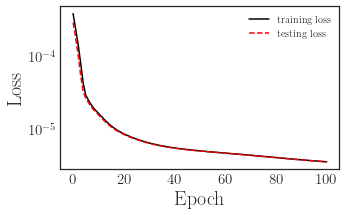

In [9]:
# Device configuration CPU or GPU
from torch.utils.data import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training Parameters
learning_rate = 1e-2
num_epochs  = 100
batch_size  = 1500
ae_model    = autoencoder().to(device)
criterion   = torch.nn.MSELoss()
optimizer   = torch.optim.Adam(ae_model.parameters(), lr=learning_rate)

data_loader = DataLoader(dataset=torch.from_numpy(data_in_net).float(),
                         batch_size=batch_size, 
                         shuffle=True)

test_loader = DataLoader(dataset=torch.from_numpy(data_in_net).float(),
                         batch_size=batch_size, 
                         shuffle=True)

epoch_plot_train = []
loss_plot_train  = []
epoch_plot_test = []
loss_plot_test  = []

for epoch in tqdm(range(num_epochs+1), desc='Epoches'):
    # Training Loop
    ae_model.train()
    loss_ave = 0
    for batch_idx, x in enumerate(data_loader):
        x_train = x.to(device)
        y_train = x.to(device)
        y_pred  = ae_model(x_train)
        loss    = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_ave += loss.item()

    loss_ave = loss_ave / len(data_loader.dataset)
    epoch_plot_train.append(epoch)
    loss_plot_train.append(loss_ave)
    
    # Testing Loop
    ae_model.eval()
    test_loss_ave = 0
    with torch.no_grad():
        for batch_idx, x_test in enumerate(test_loader):
            x_test    = x_test.to(device)
            y_test    = x_test.to(device)
            y_pred    = ae_model(x_test)
            test_loss = criterion(y_pred, y_test)
            test_loss_ave += test_loss.item()

    test_loss_ave /= len(test_loader.dataset)
    epoch_plot_test.append(epoch)
    loss_plot_test.append(test_loss_ave)

# Plot train loss vs epoch
fig, ax1 = plt.subplots(1,1, figsize=(5,3))
ax1.plot(epoch_plot_train, loss_plot_train, c='k', label='training loss')
ax1.plot(epoch_plot_test, loss_plot_test, '--', c='r', label='testing loss')
ax1.set_xlabel('Epoch');
ax1.set_ylabel('Loss');
ax1.set_yscale('log');
ax1.legend();

### Get the NLPC values
Bottleneck neurons are nonlinear function of $[T, Y_i(i=1,\cdots,n_s)]$ which 
are going to parameterize our manifold.

These values are similar to $\xi$ in RCCE and RRM methods, eigenvectors in ILDM and CSP methods.

**As apposed to the methods I mentioned, they are nonlinear functions of $[T, Y_i(i=1,\cdots,n_s)]$**.
**They will be similar to $\phi$s in Diffusion Maps**

- Advantages compared to DMAP:
    - We can try on very large dataset since we do not need the distance matrix which can cause *out of memory* issue very fast and can be *time consuming* as well.
    - We can train on GPU: In this example we have 12000 points on GPU it will be less than 10 seconds.
    - For DMAP it is practically impossible on our laptops.
    - It will give you not only the projection map (Encoder), but also the lifting function (Decoder).
    - In DMAP we need Nystrom for projection and Geometric Harmonic to lift
    
### Plots
Here I plot Temperature, and mass fractions of Hydrogen and H2O as the function of two NLPC values $\psi$.

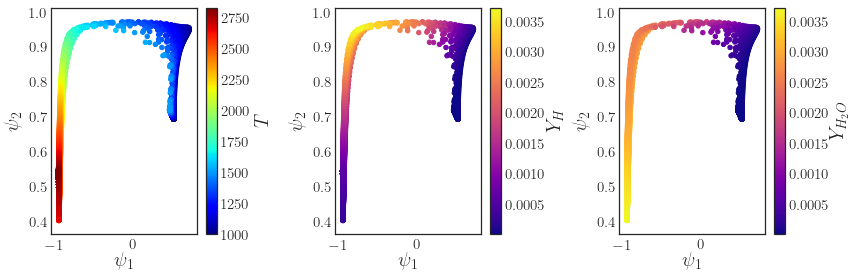

In [10]:
with torch.no_grad():
     nlpc = ae_model.encode(torch.from_numpy(data_in_net).float())
nlpc = nlpc.numpy()

marker_size = 20

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
sc = ax1.scatter(nlpc[:,0], nlpc[:,1], 
                 c=dataset[:,2], cmap='jet', 
                 s=marker_size, rasterized=True);
ax1.set_xlabel(r'$\psi_1$');
ax1.set_ylabel(r'$\psi_2$');
cname = plt.colorbar(sc, ax=ax1)
cname.set_label(r'$T$')

sc2 = ax2.scatter(nlpc[:,0], nlpc[:,1], 
                  c=dataset[:,4], cmap='plasma', 
                  s=marker_size, rasterized=True);
ax2.set_xlabel(r'$\psi_1$');
ax2.set_ylabel(r'$\psi_2$');
cname2 = plt.colorbar(sc2, ax=ax2)
cname2.set_label(r'$Y_{H}$')

sc3 = ax3.scatter(nlpc[:,0], nlpc[:,1], 
                  c=dataset[:,9], cmap='plasma', 
                  s=marker_size, rasterized=True);
ax3.set_xlabel(r'$\psi_1$');
ax3.set_ylabel(r'$\psi_2$');
cname3 = plt.colorbar(sc2, ax=ax3)
cname3.set_label(r'$Y_{H_2O}$')

plt.tight_layout()

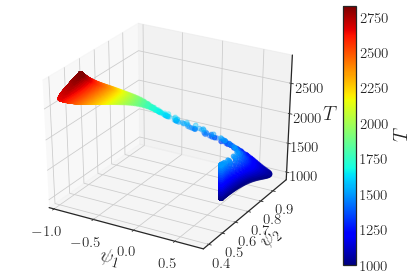

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
sc1 = ax1.scatter(nlpc[:,0], nlpc[:,1], 
                 dataset[:,2], 
                 c=dataset[:,2], cmap='jet',
                 s=marker_size, rasterized=True);
ax1.set_xlabel(r'$\psi_1$')
ax1.set_ylabel(r'$\psi_2$')
ax1.set_zlabel(r'$T$')
cname1 = plt.colorbar(sc1, ax=ax1)
cname1.set_label(r'$T$')
plt.tight_layout()